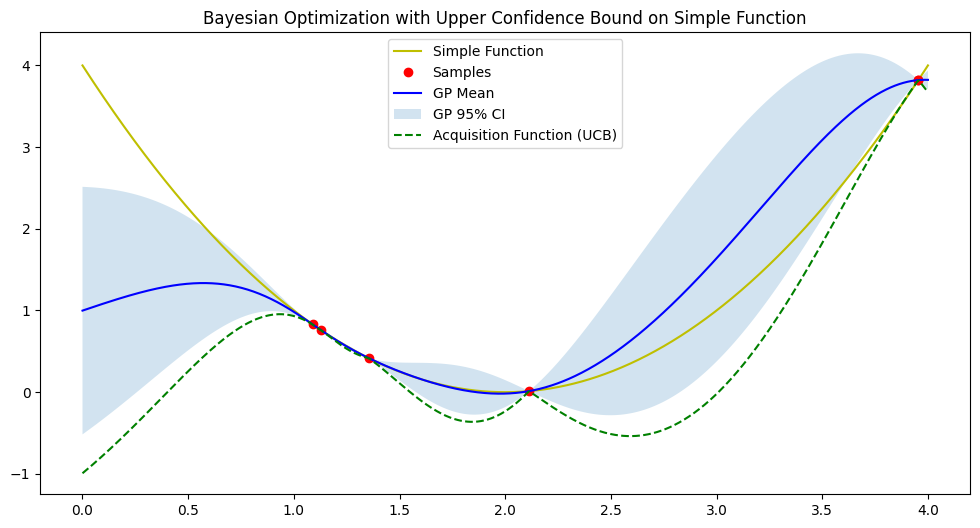

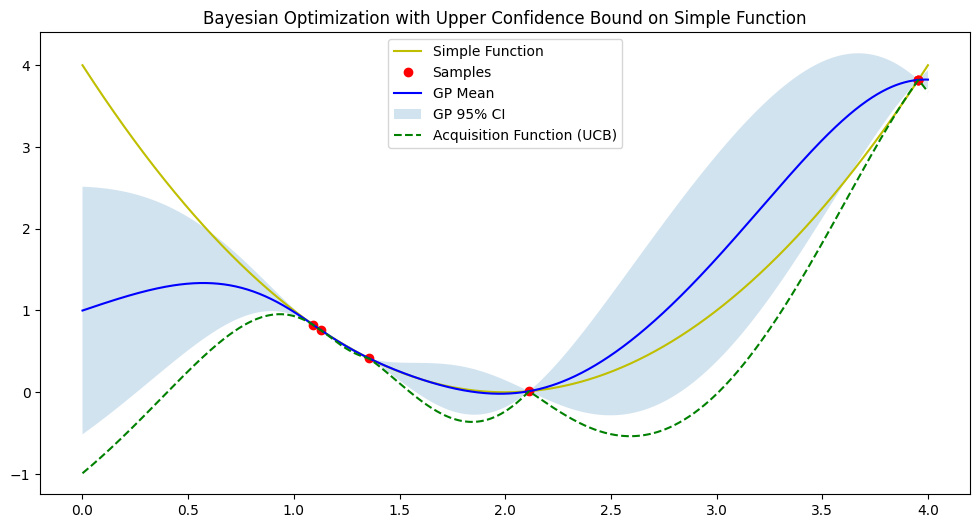

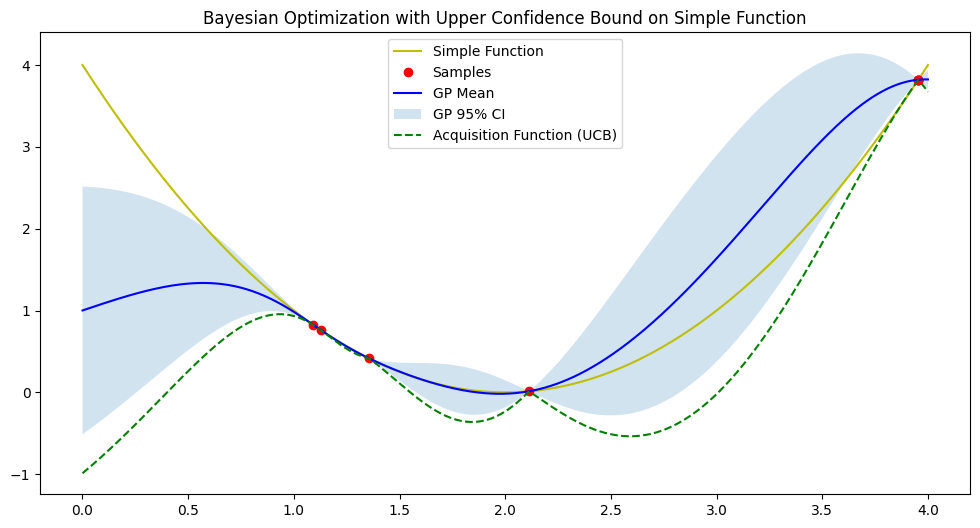

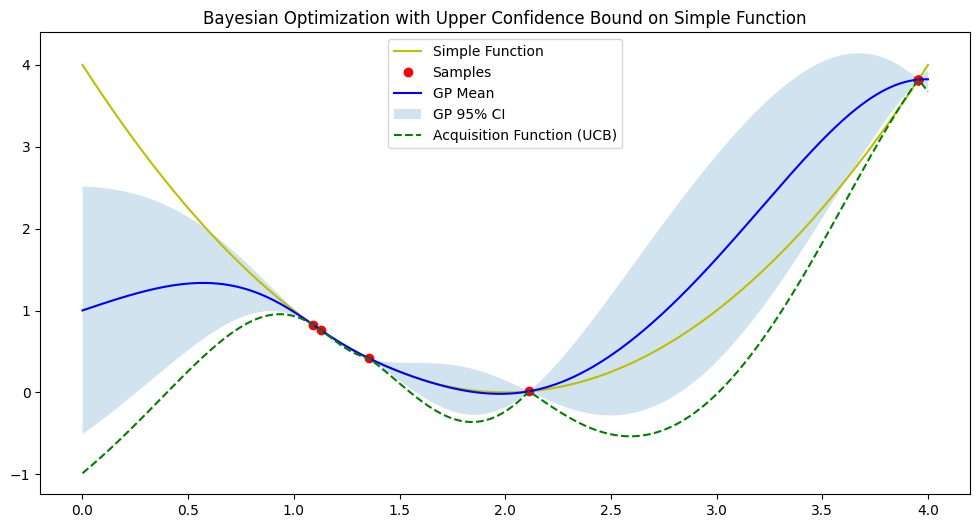

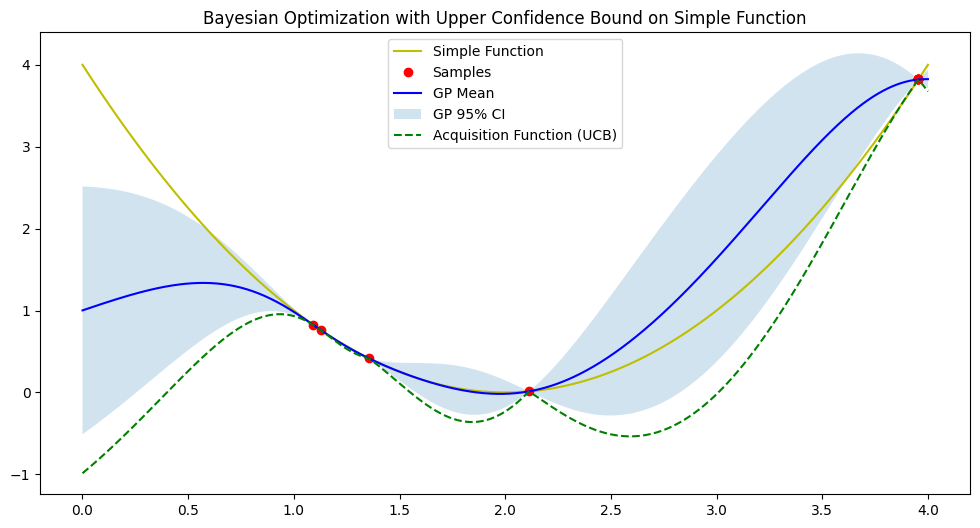

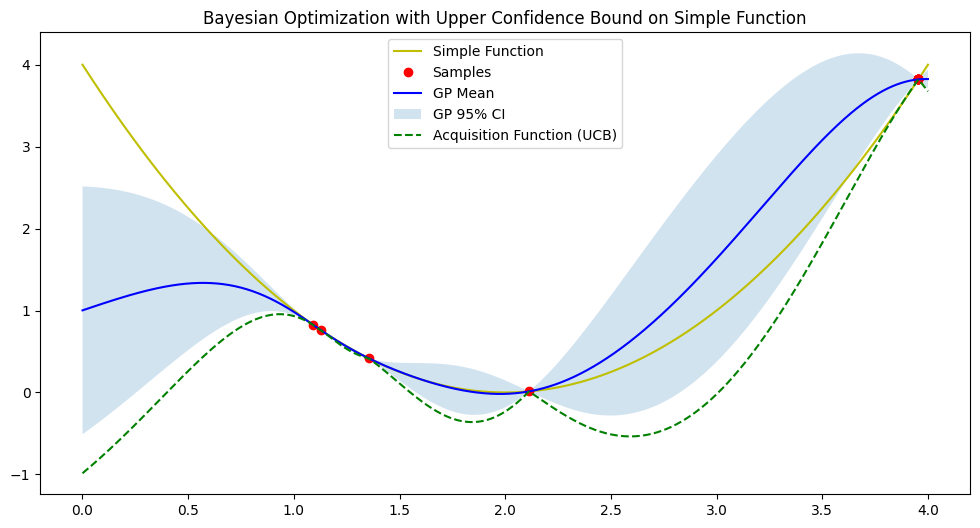

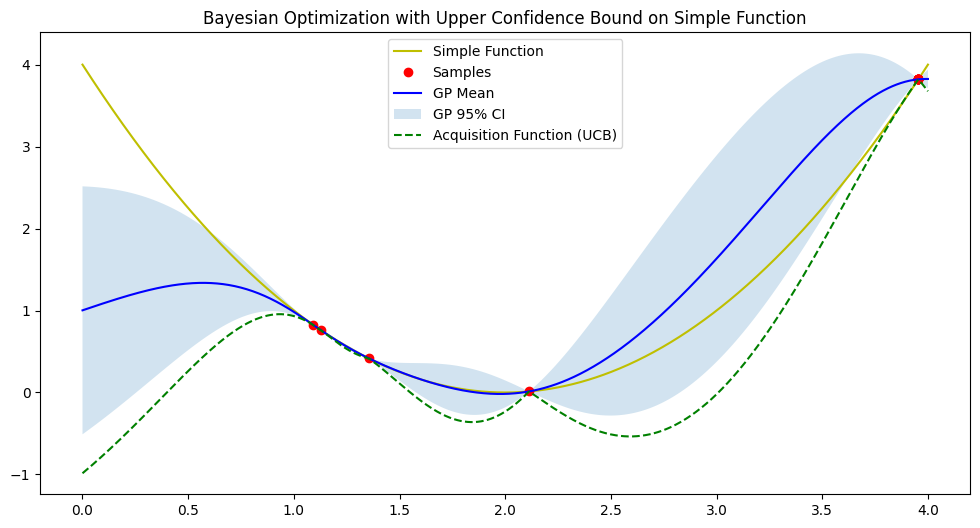

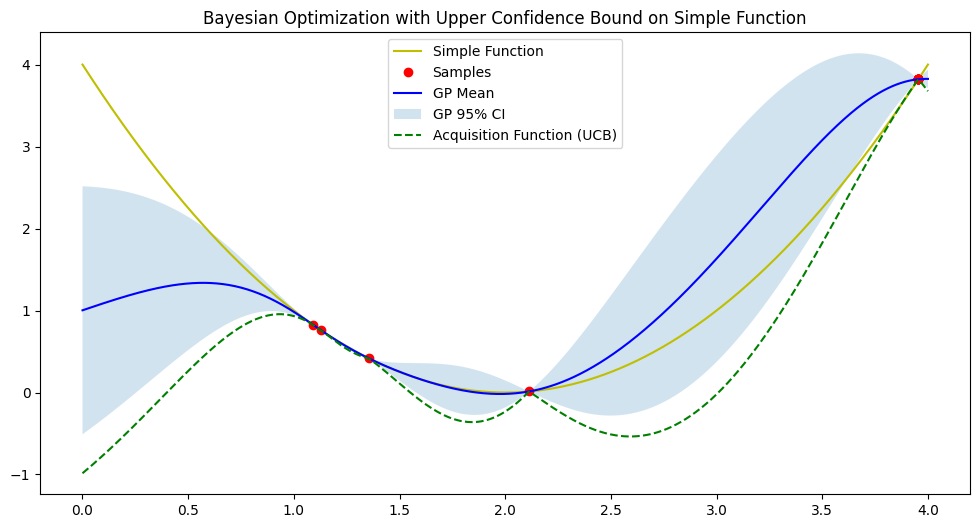

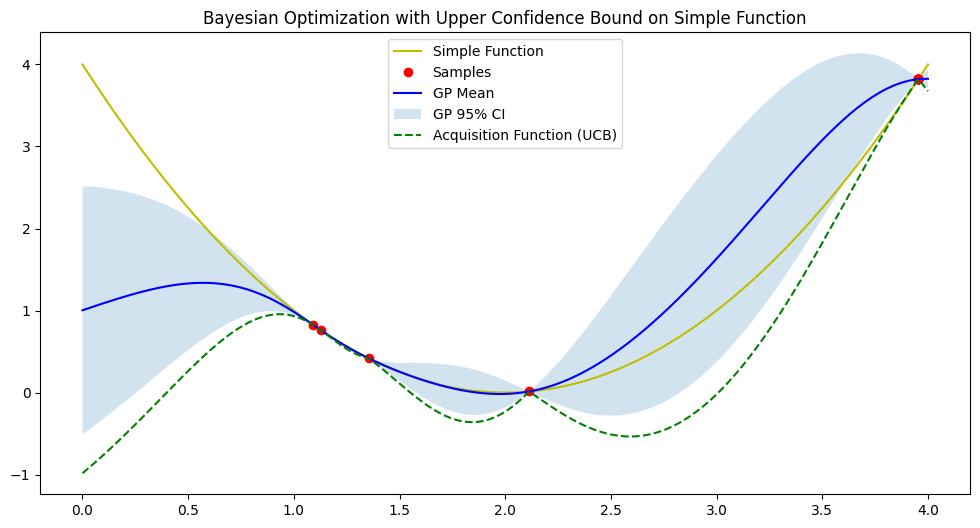

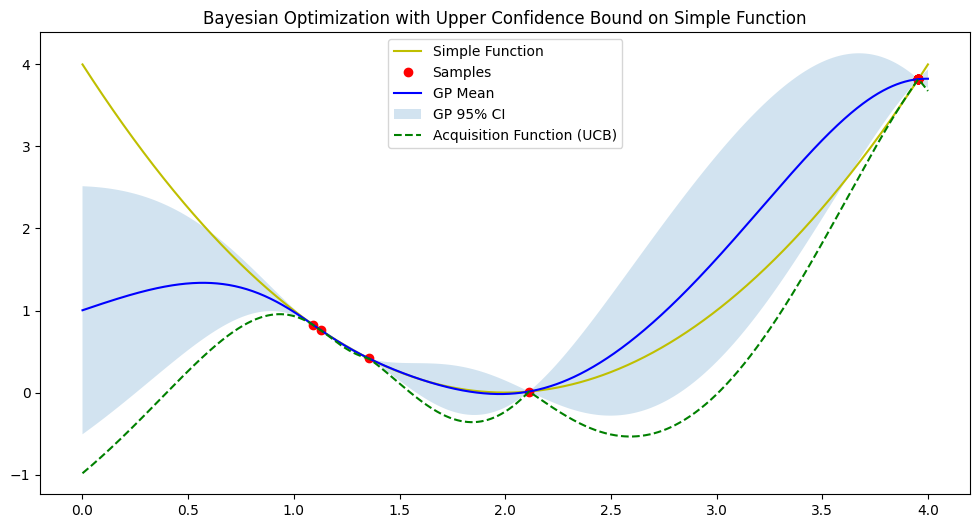

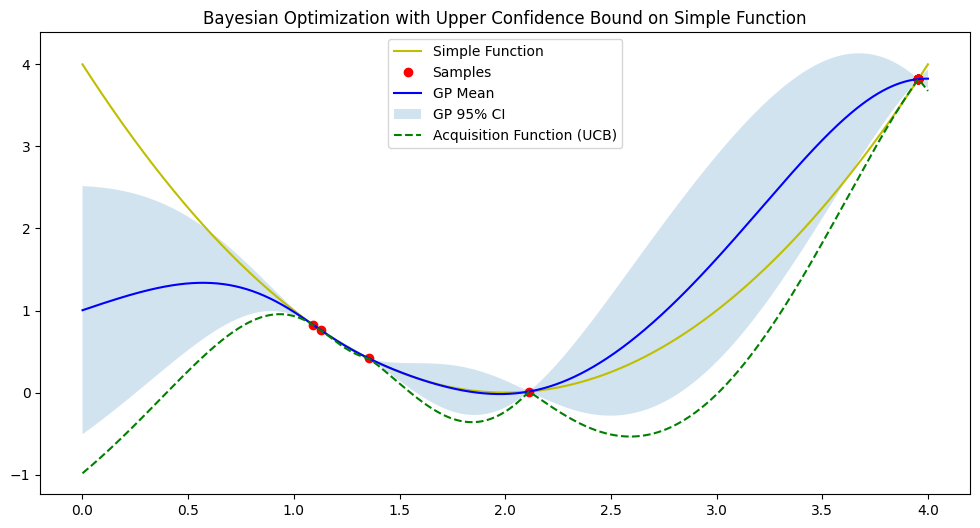

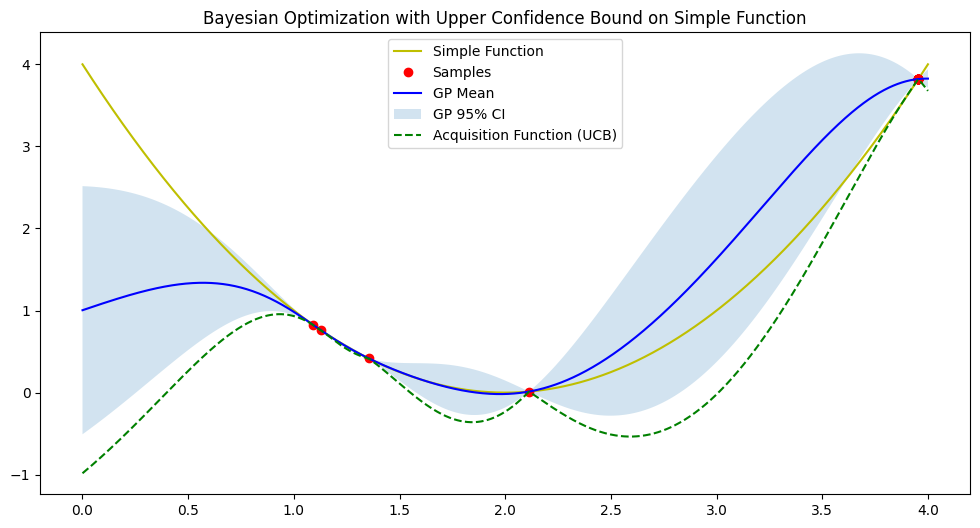

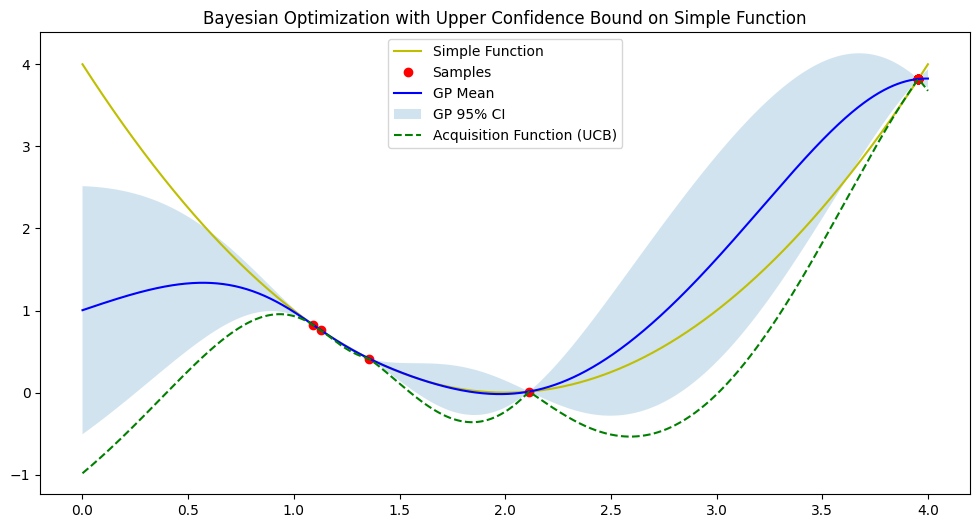

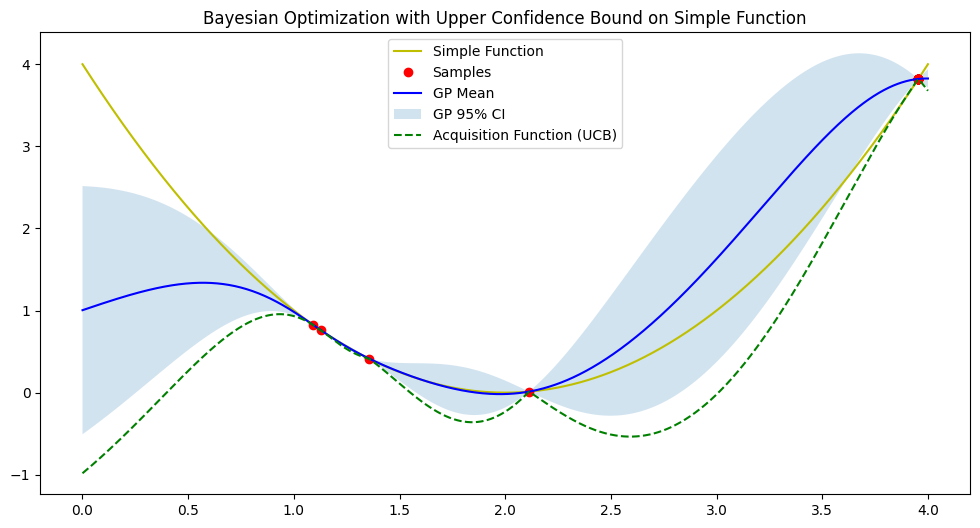

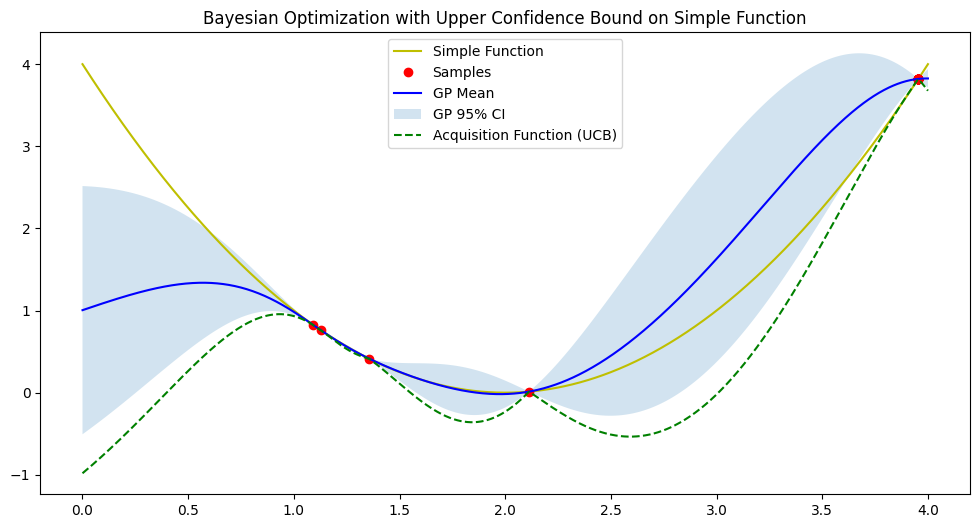

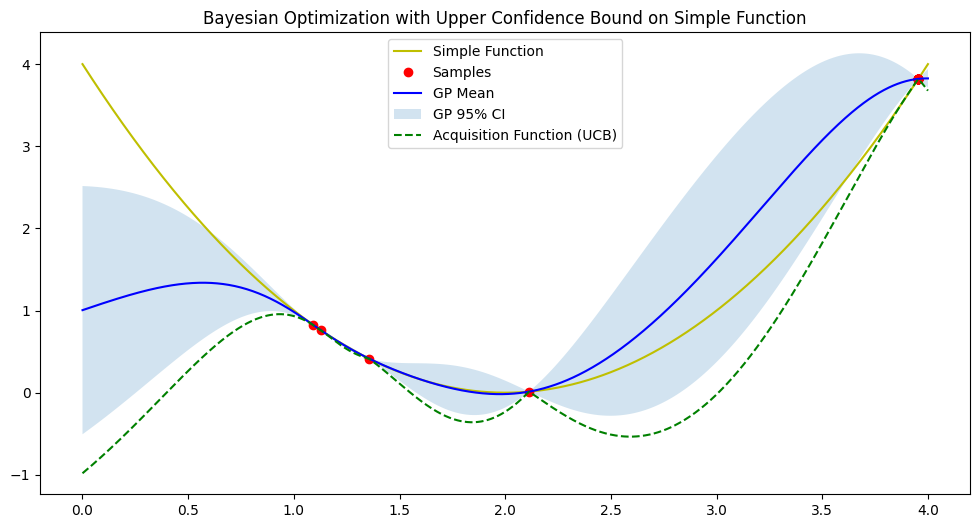

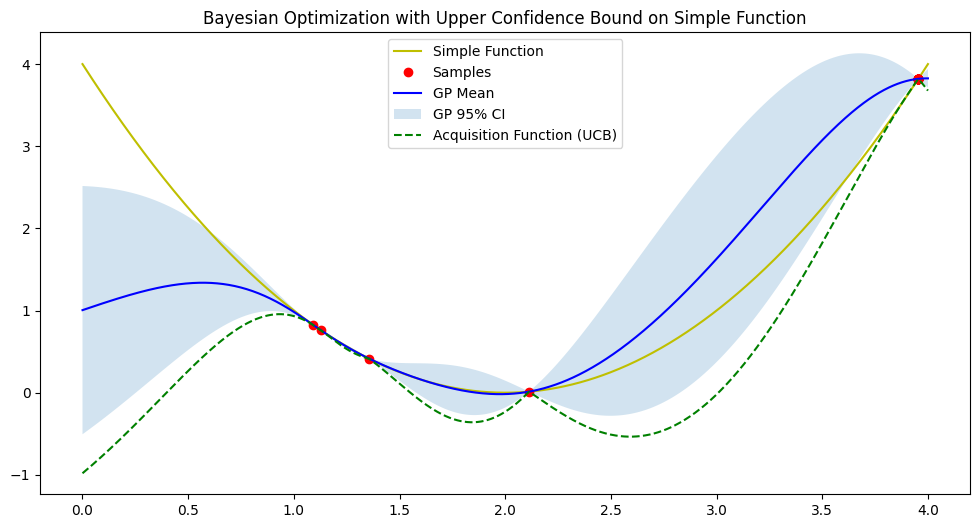

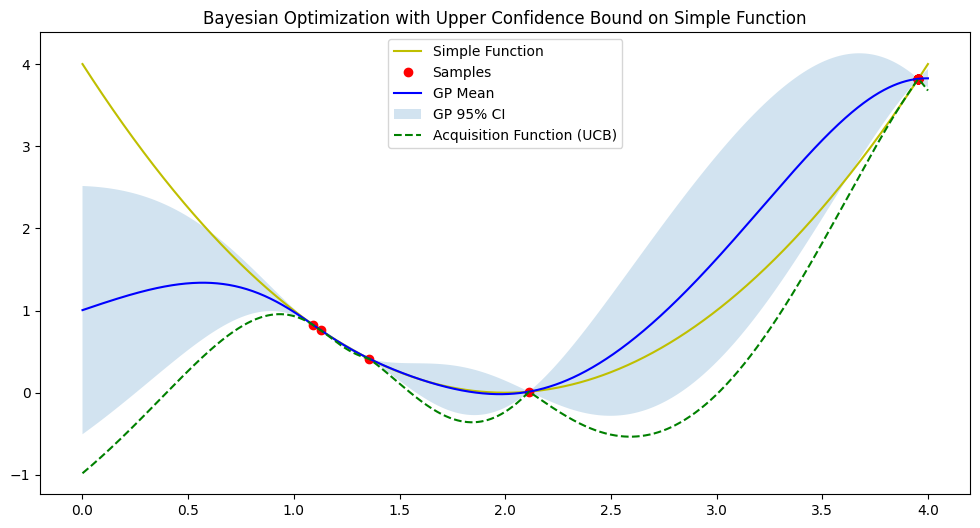

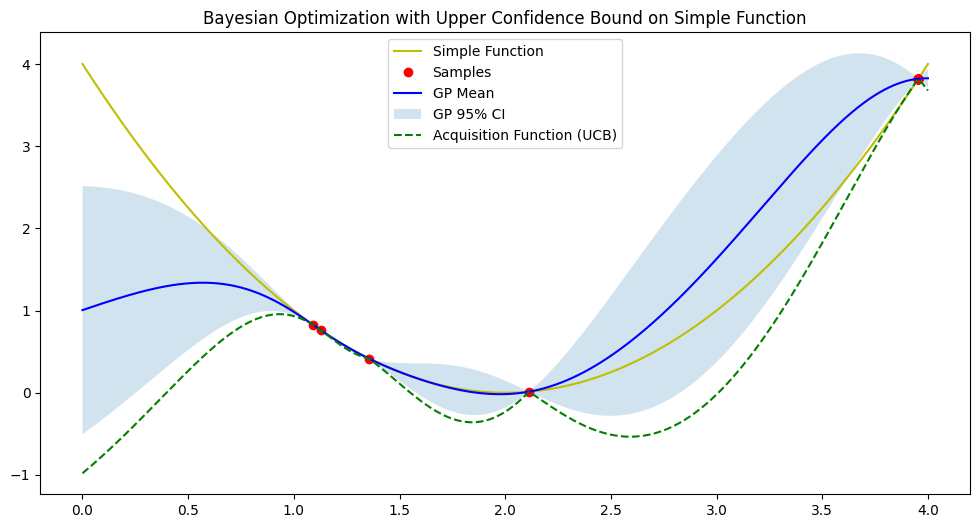

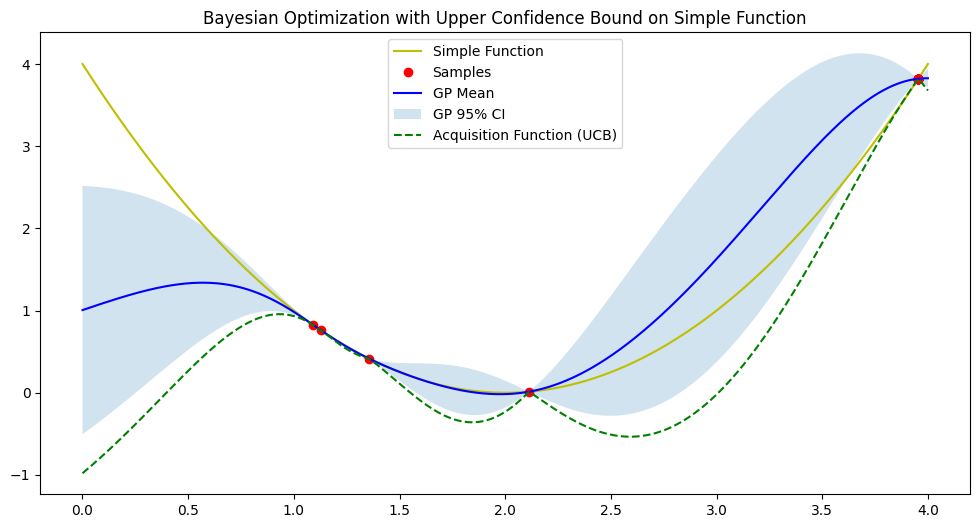

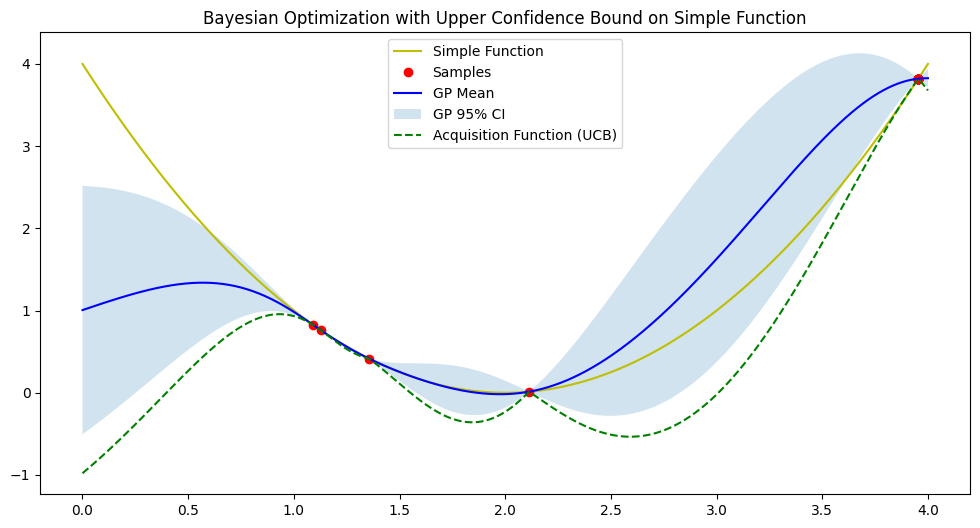

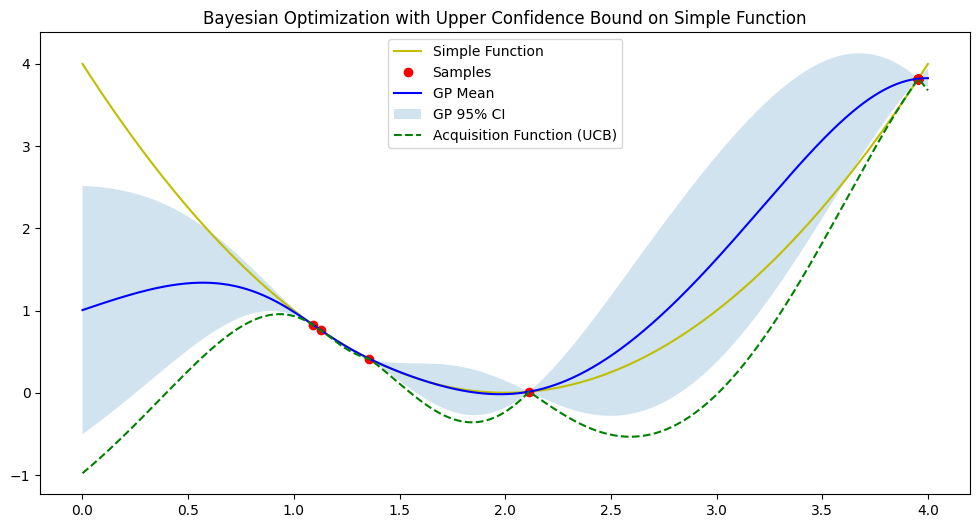

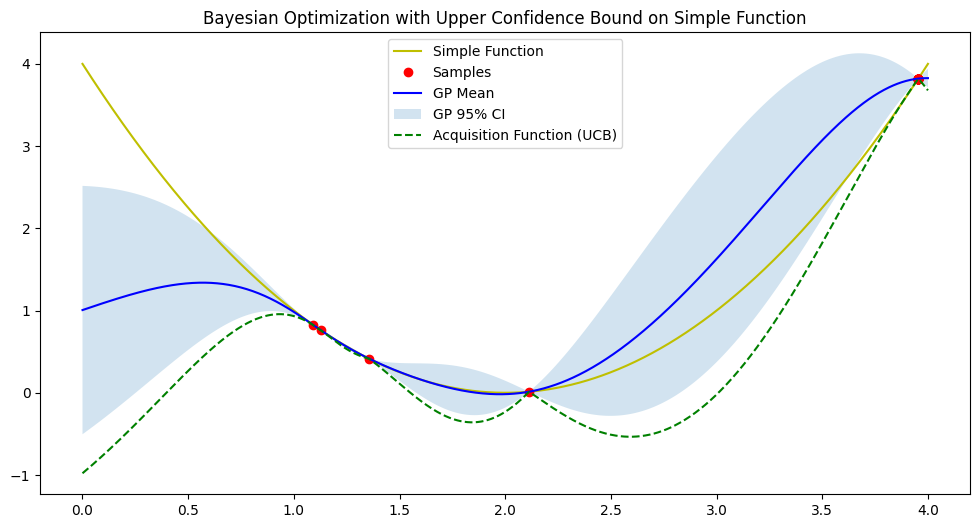

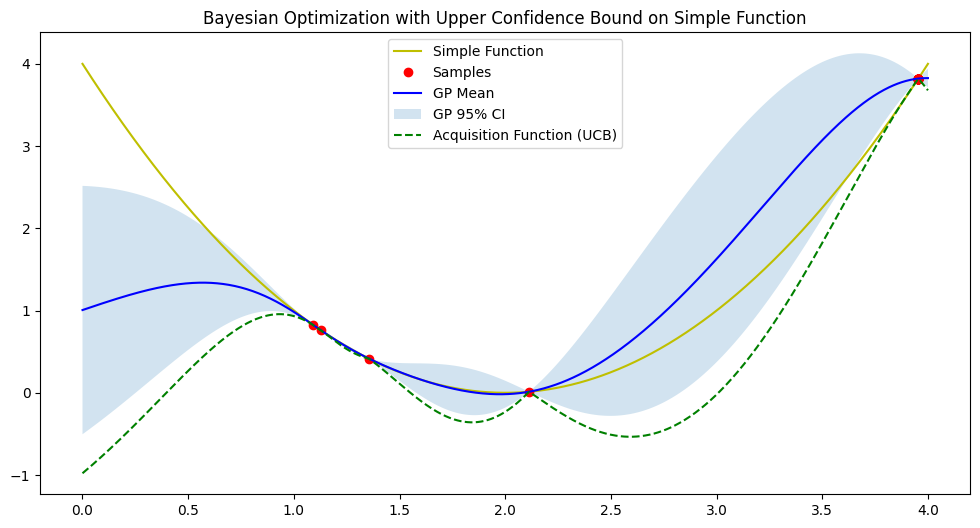

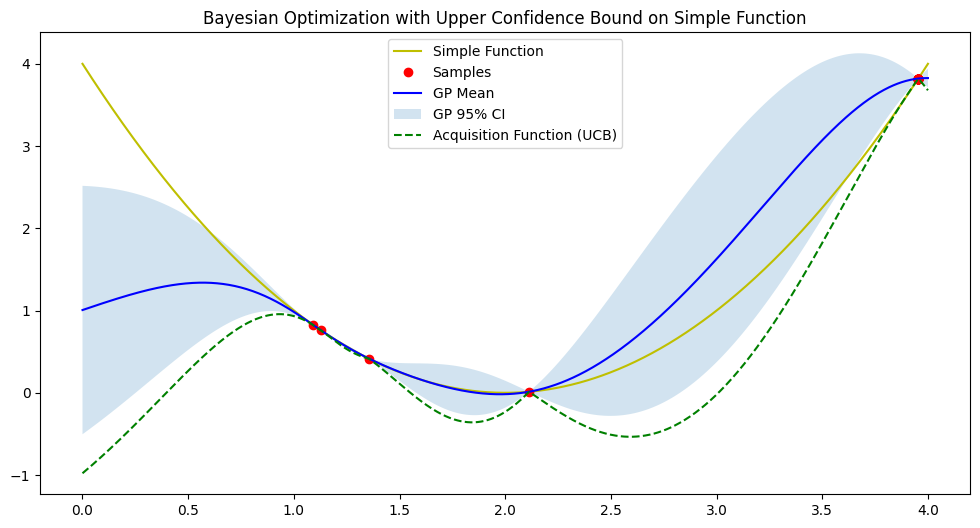

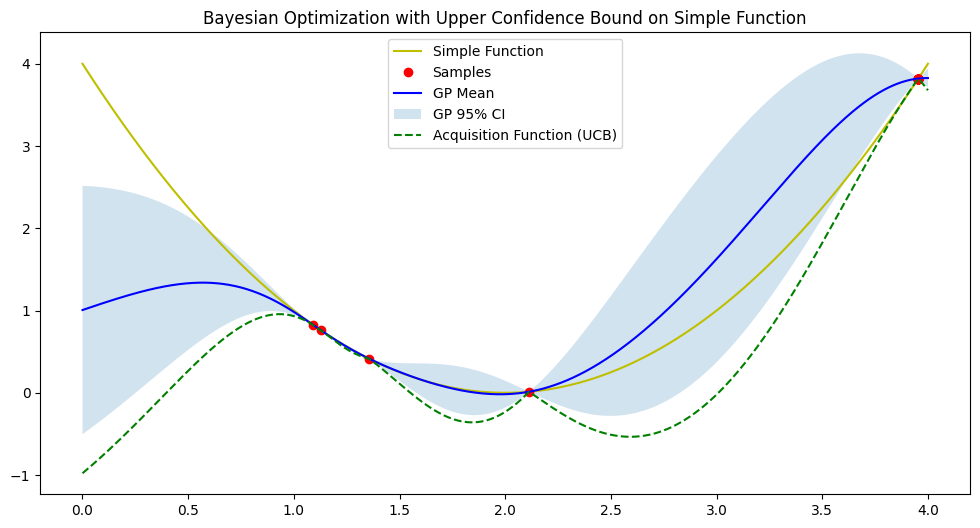

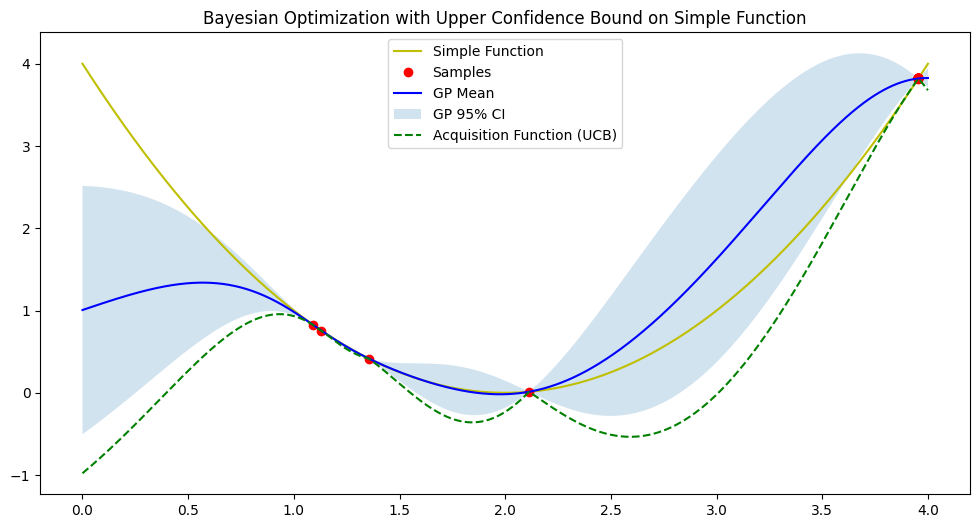

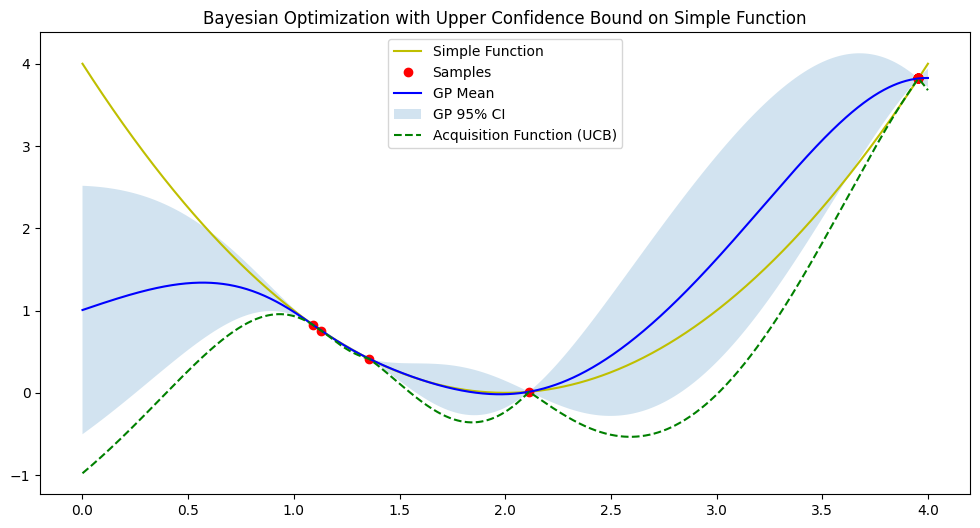

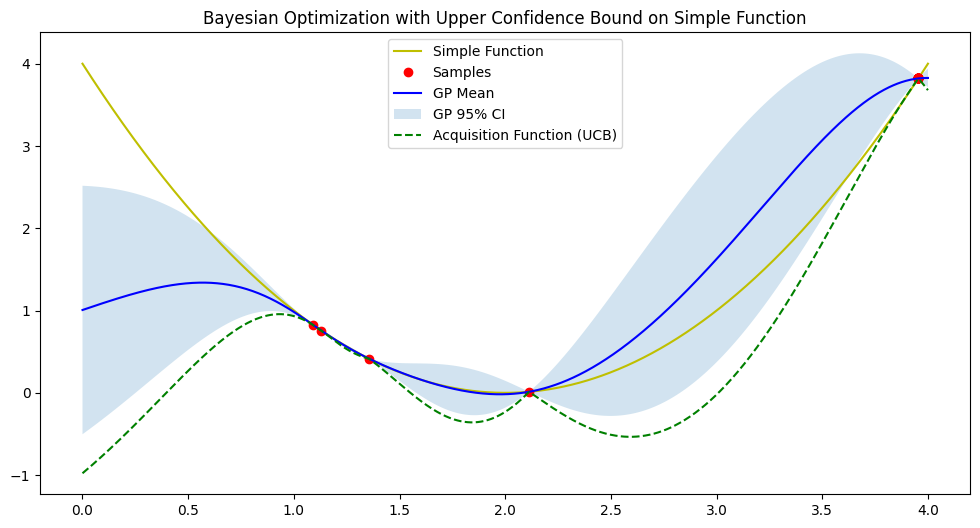

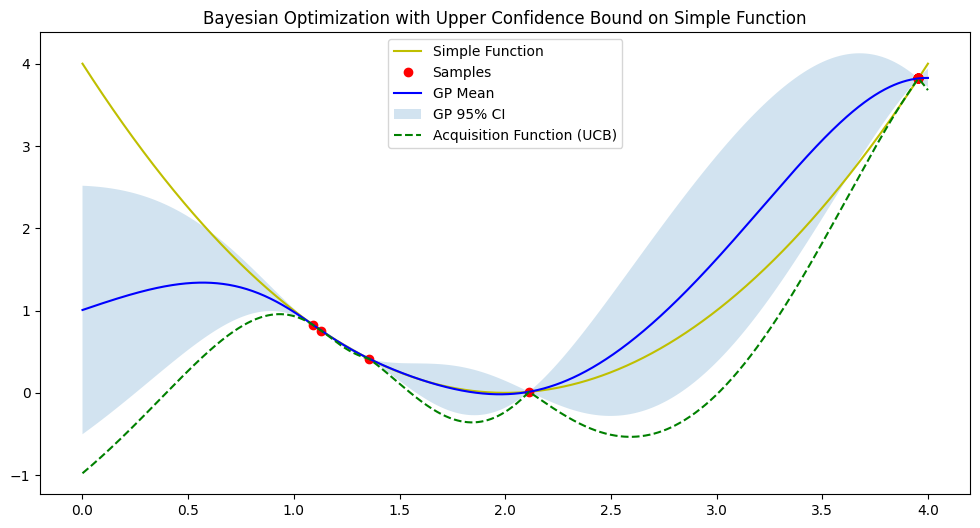

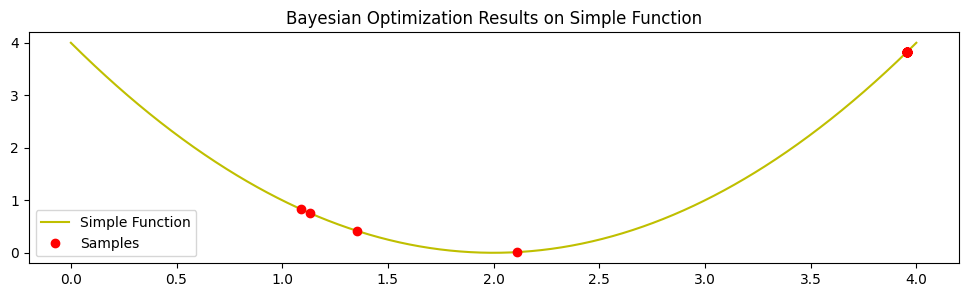

Best value found: y = 0.0126819524885297 at x = 2.112614175344535


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern


# Define a simple test function to be minimized
def simple_function(x):
    return (x - 2) ** 2


# Define the acquisition function (Upper Confidence Bound)
def upper_confidence_bound(X, gpr, kappa=2.576):
    mu, sigma = gpr.predict(X, return_std=True)
    return mu - kappa * sigma


# Propose the next sampling point by optimizing the acquisition function
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = bounds.shape[0]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)


# Bayesian Optimization loop
def bayesian_optimization(n_iters, sample_loss, bounds, n_pre_samples=5):
    X_sample = np.random.uniform(
        bounds[:, 0], bounds[:, 1], size=(n_pre_samples, bounds.shape[0])
    )
    Y_sample = sample_loss(X_sample)

    kernel = Matern(nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

    for i in range(n_iters):
        gpr.fit(X_sample, Y_sample)

        X_next = propose_location(
            upper_confidence_bound, X_sample, Y_sample, gpr, bounds
        )
        Y_next = sample_loss(X_next)

        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

        # Plot the acquisition function
        plot_acquisition_function(X_sample, Y_sample, gpr, bounds)

    return X_sample, Y_sample


# Plot the acquisition function
def plot_acquisition_function(X_sample, Y_sample, gpr, bounds, kappa=2.576):
    X = np.linspace(bounds[:, 0], bounds[:, 1], 1000).reshape(-1, 1)
    Y = simple_function(X)
    mu, sigma = gpr.predict(X, return_std=True)
    acquisition = upper_confidence_bound(X, gpr, kappa)

    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "y-", label="Simple Function")
    plt.plot(X_sample, Y_sample, "ro", label="Samples")
    plt.plot(X, mu, "b-", label="GP Mean")
    plt.fill_between(
        X.ravel(), mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, label="GP 95% CI"
    )
    plt.plot(X, acquisition, "g--", label="Acquisition Function (UCB)")
    plt.legend()
    plt.title("Bayesian Optimization with Upper Confidence Bound on Simple Function")
    plt.show()


# Plot the results
def plot_results(X_sample, Y_sample, bounds):
    X = np.linspace(bounds[:, 0], bounds[:, 1], 1000).reshape(-1, 1)
    Y = simple_function(X)

    plt.figure(figsize=(12, 3))
    plt.plot(X, Y, "y-", label="Simple Function")
    plt.plot(X_sample, Y_sample, "ro", label="Samples")
    plt.legend()
    plt.title("Bayesian Optimization Results on Simple Function")
    plt.show()


# Define the bounds of the search space
bounds = np.array([[0.0, 4.0]])

# Run Bayesian Optimization
X_sample, Y_sample = bayesian_optimization(
    n_iters=30, sample_loss=simple_function, bounds=bounds
)

# Plot the final results
plot_results(X_sample, Y_sample, bounds)

# Print the best value found
best_index = np.argmin(Y_sample)
print(
    f"Best value found: y = {Y_sample[best_index][0]} at x = {X_sample[best_index][0]}"
)